In [3]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn.objects as so
import math
import random
from collections import namedtuple, deque
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Deep Q network for bioreactor optimisation

In this notebook, we demonstrate the key parts of a DQN agent and then apply that to the maximisation of the product output of a microbial co-culture growing in a bioreactor. 

For full details of the concepts behind this demo, please see [deep reinforcement learning for the control of microbial co-cultures in bioreactors (Treloar et al, 2020)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007783).

In [4]:
class QNetwork(nn.Module):
    """Represent the agent's policy model"""
    
    def __init__(self, state_size, action_size, layer1_size=64, layer2_size=64):
        """Build a network that can take a description of an environment's state and 
        output the value of available actions.
        
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            layer1_size (int): Number of nodes in first hidden layer
            layer2_size (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__() ## calls __init__ method of nn.Module class
        self.layer1 = nn.Linear(state_size, layer1_size)
        self.layer2 = nn.Linear(layer1_size, layer2_size)
        self.layer3 = nn.Linear(layer2_size, action_size)

    def forward(self, x):
        """Map state -> action values."""
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples"""
    
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state",
                                                                "action",
                                                                "reward",
                                                                "next_state",
                                                                "done"])

    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory"""
        return len(self.memory)

The configuration variables are similar to those from the session two notebook, with one exception - we introduce `TAU` to enable us to perform soft updates on the parameters of the $ Q_{target} $ network, so that they shift towards the $Q$ network parameters incrementally rather than duplicate them at a single time step.

We're also changing the effect of the `UPDATE_EVERY` variable - this now becomes the frequency with which we perform both the gradient descent step on the $Q$ network parameters and the soft update of the $Q_{target}$ parameters. 

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

In [6]:
class DQN_agent():
    """Agent that interacts with and learns from an environment using artificial neural networks 
    to approximate its state-action value function"""

    def __init__(self, env, state_size, action_size):
        """Initialize an Agent object

        Params
        =======
            env: an environment object
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """

        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        
        # Function approximation networks:
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.q_network_target = QNetwork(state_size, action_size).to(device)

        # Optimise the parameters in the Q network, using the learning rate defined above
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def get_explore_rate(self, episode, decay):
        """Calculates the logarithmically decreasing explore rate

        Params
        ======
            episode (int): the current episode
            decay (float): controls the rate of decay of the explore rate
        
        Returns
        =======
            explore_rate (float): the epsilon in the agent's epsilon-greedy policy
        """

        # Input validation
        if not 0 < decay:
            raise ValueError("decay needs to be above 0")
        
        # Ensure rate returned is between 0 and 1:
        min_explore_rate = 0
        max_explore_rate = 1
        explore_rate = 1.0 - math.log10(episode / decay)
        return max(min_explore_rate, min(max_explore_rate, explore_rate))
    
    def policy(self, state, epsilon=0):
        """Returns action for given state as per current policy

        Params
        ======
            state (array_like): current state
            epsilon (float): for epsilon-greedy action selection
        """

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            action_values = self.q_network(state)
        self.q_network.train()

        # Epsilon-greedy action selction
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_target(self, model, target_model):
        """Update target model parameters

        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
        """
        for target_param, local_param in zip(target_model.parameters(), model.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1-TAU)*target_param.data) 

    def update_Q(self, experiences):
        """Update value parameters using given batch of experience tuples.
        
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
        """
        states, actions, rewards, next_states, dones = experiences
        
        # We use mean squared error as the loss function
        criterion = torch.nn.MSELoss()
        # The local model is the one we need to train so we put it in training mode
        self.q_network.train()
        # Conversely, we want the target model to be in evaluation mode so that when 
        # we do a forward pass it does not calculate the gradients
        self.q_network_target.eval()
        
        with torch.no_grad():
            future_pred = self.q_network_target(next_states).detach().max(1)[0].unsqueeze(1)

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        targets = rewards + (GAMMA * future_pred * (1 - dones))

        # Shape of output from the model (batch_size, action_size) 
        predicted_targets = self.q_network(states).gather(1, actions)

        loss = criterion(predicted_targets, targets).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, n_episodes=200, max_t=1000, decay=None, verbose=True):
        """Deep Q-Learning
        
        Params
        ======
            n_episodes (int): maximum number of training epsiodes
            max_t (int): maximum number of timesteps per episode
            decay (float): controls the rate of decay of the explore rate
            verbose (bool): whether to print updates on the training process
        
        Returns
        =======
            returns (list[float]): episode returns for analysis of training performance
        """
        returns = [] # list containing total reward from each episode

        # Reasonable default value for explore_rate decay:
        if not decay:
            decay = n_episodes / 11

        for episode in range(1, n_episodes+1):
            explore_rate = self.get_explore_rate(episode, decay)
            state, prob = self.env.reset()
            episode_return = 0

            for t in range(max_t): 
                action = self.policy(state, explore_rate)
                next_state, reward, done, info, prob = self.env.step(action)

                self.memory.add(state, action, reward, next_state, done)
                # If enough samples are available in memory, get random subset and learn:
                if len(self.memory) > BATCH_SIZE and t % UPDATE_EVERY == 0:
                    experience = self.memory.sample()
                    self.update_Q(experience)
                    self.update_target(self.q_network, self.q_network_target)
                state = next_state
                episode_return += reward
                if done:
                    break
        
            returns.append(episode_return)
            # If verbose mode is switched on, log returns every 10 episodes:
            if verbose and episode % 10 == 0:
                print(f'Episode {episode}\tExplore rate {explore_rate:.2f}\tReturn {episode_return:.2f}')
        
        return returns
    

In [7]:
1/60

0.016666666666666666

In [8]:
class BioreactorEnv():

    '''
    Chemostat environment that can handle an arbitrary number of bacterial strains where all are being controlled

    '''

    def __init__(self, xdot, reward_func, sampling_time, num_controlled_species, initial_x, max_t, n_states = 10, n_actions = 2, continuous_s = False):
        '''
        Parameters:
            param_file: path of a yaml file contining system parameters
            reward_func: python function used to coaculate reward: reward = reward_func(state, action, next_state)
            sampling_time: time between sampl-and-hold intervals
            scaling: population scaling to prevent neural network instability in agent, aim to have pops between 0 and 1. env returns populations/scaling to agent
        '''
        one_min = 0.016666666667
        
        self.scaling = 1

        self.xdot = xdot
        self.xs = []
        self.us = []
        self.sampling_time = sampling_time*one_min
        self.reward_func = reward_func

        self.u_bounds = [0,0.1]
        self.N_bounds = [0, 50000]

        self.u_disc = n_actions
        self.N_disc = n_states
        self.num_controlled_species = num_controlled_species
        self.initial_x = initial_x
        self.max_t = max_t
        self.continuous_s = continuous_s

    def step(self, action):
        '''
        Performs one sampling and hold interval using the action provided by a reinforcment leraning agent

        Parameters:
            action: action chosen by agent
        Returns:
            state: scaled state to be observed by agent
            reward: reward obtained buring this sample-and-hold interval
            done: boolean value indicating whether the environment has reached a terminal state
        '''
        u = self.action_to_u(action)

        #add noise
        #Cin = np.random.normal(Cin, 0.1*Cin) #10% pump noise

        self.us.append(u)

        ts = [0, self.sampling_time]


        sol = odeint(self.xdot, self.xs[-1], ts, args=(u,))[1:]

        self.xs.append(sol[-1,:])

        self.state = self.get_state()

        reward, done = self.reward_func(self.xs[-1])
        
        if len(self.xs) == self.max_t:
            done = True

        return self.state, reward, done, None, 1

    def get_state(self):
        '''
        Gets the state (scaled bacterial populations) to be observed by the agent

        Returns:
            scaled bacterial populations
        '''
        if not self.continuous_s:
            return self.pop_to_state(self.xs[-1][0:self.num_controlled_species])
        else:
            return self.xs[-1][0:self.num_controlled_species]/100000

    def action_to_u(self,action):
        '''
        Takes a discrete action index and returns the corresponding continuous state
        vector

        Paremeters:
            action: the descrete action
            num_species: the number of bacterial populations
            num_Cin_states: the number of action states the agent can choose from
                for each species
            Cin_bounds: list of the upper and lower bounds of the Cin states that
                can be chosen
        Returns:
            state: the continuous Cin concentrations correspoding to the chosen
                action
        '''

        # calculate which bucket each eaction belongs in
        buckets = np.unravel_index(action, [self.u_disc] * self.num_controlled_species)

        # convert each bucket to a continuous state variable
        u = []
        for r in buckets:
            u.append(self.u_bounds[0] + r*(self.u_bounds[1]-self.u_bounds[0])/(self.u_disc-1))

        u = np.array(u).reshape(self.num_controlled_species,)

        return np.clip(u, self.u_bounds[0], self.u_bounds[1])

    def pop_to_state(self, N):
        '''
        discritises the population of bacteria to a state suitable for the agent
        :param N: population
        :return: discitised population
        '''
        step = (self.N_bounds[1] - self.N_bounds[0])/self.N_disc

        N = np.clip(N, self.N_bounds[0], self.N_bounds[1]-1)


        return np.ravel_multi_index((N//step).astype(np.int32), [self.N_disc]*self.num_controlled_species)

    def reset(self, initial_x = None):
        '''
        Resets env to inital state:

        Parameters:
            initial_S (optional) the initial state to be reset to if different to the default
        Returns:
            The state to be observed by the agent
        '''
        
        if initial_x is None:
            initial_x = self.initial_x

        self.xs = [initial_x]
        self.us = []
        return (self.get_state(),1)

In [9]:
def monod(C, C0, umax, Km, Km0):
    '''
    Calculates the growth rate based on the monod equation

    Parameters:
        C: the concetrations of the auxotrophic nutrients for each bacterial
            population
        C0: concentration of the common carbon source
        Rmax: array of the maximum growth rates for each bacteria
        Km: array of the saturation constants for each auxotrophic nutrient
        Km0: array of the saturation constant for the common carbon source for
            each bacterial species
    '''

    # convert to numpy

    growth_rate = ((umax * C) / (Km + C)) * (C0 / (Km0 + C0))

    return growth_rate

def xdot_product(x, t, u):
    '''
    Calculates and returns derivatives for the numerical solver odeint

    Parameters:
        S: current state
        t: current time
        Cin: array of the concentrations of the auxotrophic nutrients and the
            common carbon source
        params: list parameters for all the exquations
        num_species: the number of bacterial populations
    Returns:
        xdot: array of the derivatives for all state variables
    '''
    q = 0.5
    y, y0, umax, Km, Km0 = [np.array(x) for x in [[480000., 480000.], [520000., 520000.], [1., 1.1], [0.00048776, 0.000000102115], [0.00006845928, 0.00006845928]]]

    # extract variables
    N = x[:2]
    C = x[2:4]
    C0 = x[4]
    A = x[5]
    B = x[6]
    P = x[7]

    R = monod(C, C0, umax, Km, Km0)

    # calculate derivatives
    dN = N * (R - q)  # q term takes account of the dilution
    dC = q * (u - C) - (1 / y) * R * N
    dC0 = q*(0.1 - C0) - sum(1/y0[i]*R[i]*N[i] for i in range(2))

    dA = N[0] - 2 * A ** 2 * B - q * A
    dB = N[1] - A ** 2 * B - q * B
    dP = A ** 2 * B - q * P

    # consstruct derivative vector for odeint
    xdot = np.append(dN, dC)
    xdot = np.append(xdot, dC0)
    xdot = np.append(xdot, dA)
    xdot = np.append(xdot, dB)
    xdot = np.append(xdot, dP)


    return xdot

In [10]:
def reward_f(x):
    '''
    caluclates the reward based on the rate of product output
    :param x:
    :return:
    '''
    P = x[-1]


    if x[0] < 1000 or x[1] < 1000:
        reward = -1
        done = True
    else:
        reward = P/100000
        done = False

    return reward, done

num_controlled_species = 2

sampling_time = 10  # minutes
n_episodes = 1000

t_steps = int((24 * 60) / sampling_time)  # set this to 24 hours

initial_x = np.array([20000, 30000, 0., 0., 1., 0., 0., 0.]) # the initial state

env = BioreactorEnv(xdot_product, reward_f, sampling_time,
                    num_controlled_species, initial_x, t_steps, continuous_s = True)  # initalise the chemostat environment

n_states = 2
n_actions = 4
agent = DQN_agent(env, n_states, n_actions)
n_episodes = 1000
# train the agent
returns = agent.train(n_episodes)

/opt/conda/envs/l2dVE/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Episode 10	Explore rate 1.00	Return 26.74
Episode 20	Explore rate 1.00	Return 27.06


Episode 30	Explore rate 1.00	Return 29.46
Episode 40	Explore rate 1.00	Return 30.92
Episode 50	Explore rate 1.00	Return 28.74
Episode 60	Explore rate 1.00	Return 26.87
Episode 70	Explore rate 1.00	Return 28.56
Episode 80	Explore rate 1.00	Return 25.58
Episode 90	Explore rate 1.00	Return 28.16
Episode 100	Explore rate 0.96	Return 33.24
Episode 110	Explore rate 0.92	Return 34.29
Episode 120	Explore rate 0.88	Return 34.02
Episode 130	Explore rate 0.84	Return 36.20
Episode 140	Explore rate 0.81	Return 41.00
Episode 150	Explore rate 0.78	Return 31.18
Episode 160	Explore rate 0.75	Return 38.62
Episode 170	Explore rate 0.73	Return 37.47
Episode 180	Explore rate 0.70	Return 40.54
Episode 190	Explore rate 0.68	Return 36.12
Episode 200	Explore rate 0.66	Return 37.19
Episode 210	Explore rate 0.64	Return 36.96
Episode 220	Explore rate 0.62	Return 35.96
Episode 230	Explore rate 0.60	Return 40.88
Episode 240	Explore rate 0.58	Return 38.53
Episode 250	Explore rate 0.56	Return 40.08
Episode 260	Explor

In [11]:
n_episodes

1000

In [12]:
explore_rates = [
    agent.get_explore_rate(episode, 1.5) for episode in range(1, n_episodes+1)
]

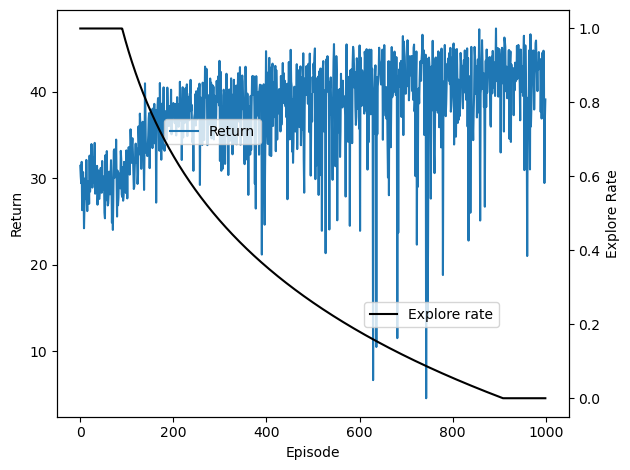

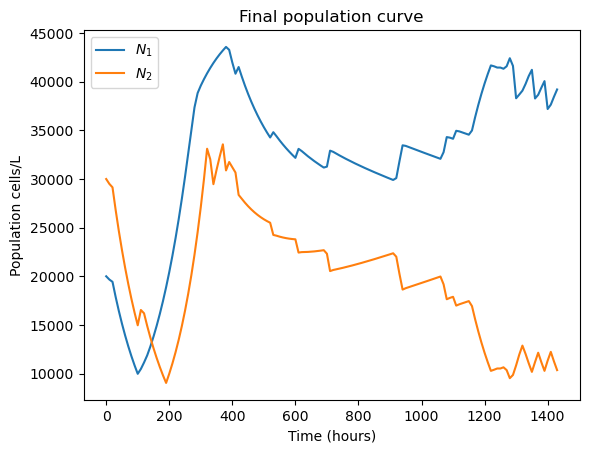

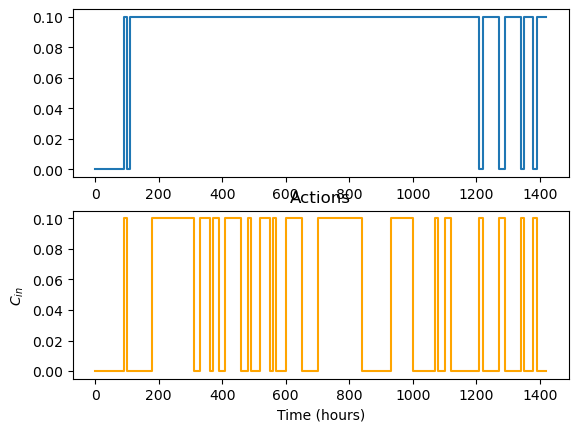

In [13]:
fig, ax1 = plt.subplots()

plt.plot(returns, label='Return')
explore_rates = [agent.get_explore_rate(episode, n_episodes / 11) for episode in range(1, n_episodes+1)]
ax1.set_ylabel('Return')
ax1.set_xlabel('Episode')
ax2 = ax1.twinx()
ax2.plot(explore_rates, color='black', label='Explore rate')
ax2.set_ylabel('Explore Rate')
ax2.set_xlabel('Episode')
plt.tight_layout()
ax1.legend(loc=(0.21, 0.67))
ax2.legend(loc=(0.6, 0.22))


plt.figure()
plt.title('Final population curve')
plt.plot(np.arange(len(env.xs)) *sampling_time, [x[0] for x in env.xs], label = '$N_1$')
plt.plot(np.arange(len(env.xs)) *sampling_time, [x[1] for x in env.xs], label = '$N_2$')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Population cells/L')

fig, axs = plt.subplots(2,1)
plt.title('Actions')
axs[0].step(np.arange(len(env.us)) * sampling_time, [x[0] for x in env.us], label = '$u_1$')
axs[1].step(np.arange(len(env.us)) * sampling_time, [x[1] for x in env.us], label = '$u_2$', color = 'orange')

plt.xlabel('Time (hours)')
plt.ylabel('$C_{in}$')

plt.show()